[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset Shape: (1139, 11)

Columns in the dataset:
['Temperature', 'Approach', 'Project ID', 'Project Name', 'Human Rating', 'Prompt_Type', 'Generated Prompt', 'Generated Rating', 'Extracted Rating', 'Whitepaper Link', 'Re-Extracted Rating']

Missing values in each column:
Temperature              0
Approach                 0
Project ID               0
Project Name             0
Human Rating            80
Prompt_Type              0
Generated Prompt         0
Generated Rating         0
Extracted Rating        53
Whitepaper Link          0
Re-Extracted Rating    488
dtype: int64

--- Descriptive Statistics ---
       Human Rating  Extracted Rating
count   1059.000000       1086.000000
mean       3.169877          3.510681
std        0.695998          1.127722
min        2.100000          1.000000
25%        2.400000          2.500000
50%        3.000000          4.000000
75%        3.900000          4.500000
max        4.400000          5.000000

Correlation between Human and LLM ratings

/tmp/ipython-input-3900244317.py:421: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consistency_df['Sentiment_Rating_Aligned'] = (



Analysis complete. All figures have been saved.


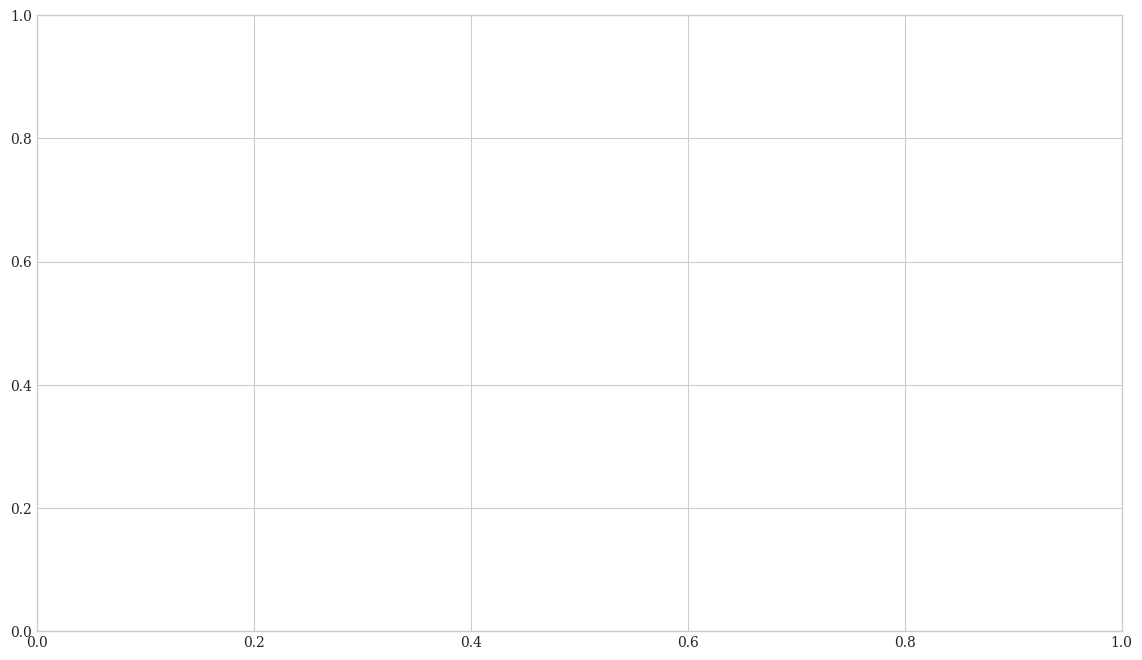

In [ ]:
# Quantitative & Qualitative analysis -- Digital Assets Paper - Code by Pejman Ebrahimi (pejman.ebrahimi@uni.li)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from wordcloud import WordCloud
from collections import Counter

# Set plotting style for publication quality
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (10, 6)


try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')

# Data
df = pd.read_excel('Data.xlsx')

# Clean up the Prompt Type column
prompt_type_mapping = {
    "1. Zero-Shot (ZS) (step-by-step instructions)": "Zero-Shot",
    "2. Few-shot (example of expected behaviors)": "Few-Shot",
    "3. Chain-of-thoughts (sequence of intermediary reasoning": "CoT",
    "4.Chain of thought including Problem context and rubric (CR)": "CoT-CR"
}

df['Prompt Type'] = df['Prompt Type'].map(lambda x: prompt_type_mapping.get(x, x))

# Force all variations of the long prompt type names to be the short names
# This is a direct string replacement to ensure all instances are caught --> Short is better!
df['Prompt Type'] = df['Prompt Type'].astype(str)
df['Prompt Type'] = df['Prompt Type'].str.replace("3. Chain-of-thoughts (sequence of intermediary reasoning", "CoT", regex=False)
df['Prompt Type'] = df['Prompt Type'].str.replace("3. Chain-of-thoughts (sequence of intermediary reasoning steps)", "CoT", regex=False)

# Rename columns with spaces for statsmodels compatibility
df = df.rename(columns={'Prompt Type': 'Prompt_Type'})


print("Dataset Shape:", df.shape)
print("\nColumns in the dataset:")
print(df.columns.tolist())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Just for check
if df['Human Rating'].dtype == 'object':
    df['Human Rating'] = pd.to_numeric(df['Human Rating'], errors='coerce')
if df['Extracted Rating'].dtype == 'object':
    df['Extracted Rating'] = pd.to_numeric(df['Extracted Rating'], errors='coerce')

# Create a function to save high-quality figures
def save_figure(fig, filename, dpi=300):
    fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches='tight')
    plt.close(fig)

# ===================== QUANTITATIVE ANALYSIS =====================

# 1. Basic statistics for the ratings
print("\n--- Descriptive Statistics ---")
rating_stats = df[['Human Rating', 'Extracted Rating']].describe()
print(rating_stats)

# Distribution of ratings
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['Human Rating'].dropna(), kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Human Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

sns.histplot(df['Extracted Rating'].dropna(), kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of LLM Ratings')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
save_figure(fig, 'rating_distributions.png')

# 2. Correlation between Human and LLM ratings (Human & Machine)
# Drop rows with missing values for correlation calculation --> another way is fillna (but for now just drop)
corr_df = df.dropna(subset=['Human Rating', 'Extracted Rating'])
correlation = corr_df['Human Rating'].corr(corr_df['Extracted Rating'])
print(f"\nCorrelation between Human and LLM ratings: {correlation:.4f}")
print(f"Number of samples used for correlation: {len(corr_df)}")

fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(x='Human Rating', y='Extracted Rating', data=corr_df, scatter_kws={'alpha':0.5}, ax=ax)
ax.set_title(f'Correlation between Human and LLM Ratings (r = {correlation:.4f})')
ax.set_xlabel('Human Rating')
ax.set_ylabel('LLM Rating')
save_figure(fig, 'rating_correlation.png')

# 3. Agreement metrics
# Use only complete cases for error metrics
mse = mean_squared_error(corr_df['Human Rating'], corr_df['Extracted Rating'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(corr_df['Human Rating'], corr_df['Extracted Rating'])
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# 4. Analysis by Approach
print("\n--- Analysis by Approach ---")
approach_stats = df.groupby('Approach')[['Human Rating', 'Extracted Rating']].agg(['mean', 'std', 'count'])
print(approach_stats)

# Calculate rating difference by approach
df['Rating_Difference'] = df['Human Rating'] - df['Extracted Rating']
approach_diff = df.groupby('Approach')['Rating_Difference'].agg(['mean', 'std', 'count']).dropna()
print("\nRating Difference by Approach (Human - LLM):")
print(approach_diff)

# Visualize ratings by approach
fig, ax = plt.subplots(figsize=(10, 6))
approach_means = df.groupby('Approach')[['Human Rating', 'Extracted Rating']].mean().reset_index()
approach_means_melted = pd.melt(approach_means, id_vars='Approach',
                               value_vars=['Human Rating', 'Extracted Rating'],
                               var_name='Rating Type', value_name='Average Rating')

sns.barplot(x='Approach', y='Average Rating', hue='Rating Type', data=approach_means_melted, ax=ax)
ax.set_title('Average Ratings by Approach')
ax.set_xlabel('Approach')
ax.set_ylabel('Average Rating')
ax.legend(title='Rating Type')
save_figure(fig, 'ratings_by_approach.png')

# 5. Analysis by Prompt Type
print("\n--- Analysis by Prompt_Type ---")
prompt_stats = df.groupby('Prompt_Type')[['Human Rating', 'Extracted Rating']].agg(['mean', 'std', 'count'])
print(prompt_stats)

prompt_diff = df.groupby('Prompt_Type')['Rating_Difference'].agg(['mean', 'std', 'count']).dropna()
print("\nRating Difference by Prompt Type (Human - LLM):")
print(prompt_diff)

# Visualize ratings by prompt type
fig, ax = plt.subplots(figsize=(10, 6))
prompt_means = df.groupby('Prompt_Type')[['Human Rating', 'Extracted Rating']].mean().reset_index()
prompt_means_melted = pd.melt(prompt_means, id_vars='Prompt_Type',
                             value_vars=['Human Rating', 'Extracted Rating'],
                             var_name='Rating Type', value_name='Average Rating')

sns.barplot(x='Prompt_Type', y='Average Rating', hue='Rating Type', data=prompt_means_melted, ax=ax)
ax.set_title('Average Ratings by Prompt Type')
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Average Rating')
ax.legend(title='Rating Type')
save_figure(fig, 'ratings_by_prompt_type.png')

# 6. Combined analysis: Approach x Prompt_Type
print("\n--- Combined Analysis: Approach x Prompt_Type ---")
combined_stats = df.groupby(['Approach', 'Prompt_Type'])[['Human Rating', 'Extracted Rating']].agg(['mean', 'std', 'count'])
print(combined_stats)

# Visualize the combined analysis
fig, ax = plt.subplots(figsize=(14, 8))
combined_means = df.groupby(['Approach', 'Prompt_Type'])[['Human Rating', 'Extracted Rating']].mean().reset_index()
combined_means_melted = pd.melt(combined_means, id_vars=['Approach', 'Prompt_Type'],
                               value_vars=['Human Rating', 'Extracted Rating'],
                               var_name='Rating Type', value_name='Average Rating')

g = sns.catplot(x='Prompt_Type', y='Average Rating', hue='Rating Type', col='Approach',
           data=combined_means_melted, kind='bar', height=5, aspect=1.2)
g.fig.suptitle('Average Ratings by Approach and Prompt Type', y=1.05, fontsize=16)
plt.tight_layout()
plt.savefig('ratings_by_approach_and_prompt.png', dpi=300, bbox_inches='tight')
plt.close()

# 7. Statistical tests
print("\n--- Statistical Tests ---")

# Use only complete cases for statistical tests
complete_df = df.dropna(subset=['Rating_Difference'])

# ANOVA for Approach effect on rating difference
model = ols('Rating_Difference ~ C(Approach)', data=complete_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA for Approach effect on rating difference:")
print(anova_table)

# ANOVA for Prompt_Type effect on rating difference
model = ols('Rating_Difference ~ C(Prompt_Type)', data=complete_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA for Prompt Type effect on rating difference:")
print(anova_table)

# Two-way ANOVA
model = ols('Rating_Difference ~ C(Approach) + C(Prompt_Type) + C(Approach):C(Prompt_Type)', data=complete_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nTwo-way ANOVA (Approach x Prompt Type) on rating difference:")
print(anova_table)

# 8. Error analysis - where are the largest discrepancies?
df['Absolute_Difference'] = abs(df['Rating_Difference'])
print("\n--- Error Analysis ---")
print("Top 10 largest rating discrepancies:")
top_discrepancies = df.sort_values('Absolute_Difference', ascending=False).dropna(subset=['Absolute_Difference']).head(10)
print(top_discrepancies[['Project ID', 'Project Name', 'Approach', 'Prompt_Type', 'Human Rating', 'Extracted Rating', 'Absolute_Difference']])

# Visualize error distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Approach', y='Absolute_Difference', data=df.dropna(subset=['Absolute_Difference']), ax=ax)
ax.set_title('Distribution of Rating Discrepancies by Approach')
ax.set_xlabel('Approach')
ax.set_ylabel('Absolute Difference |Human - LLM|')
save_figure(fig, 'error_by_approach.png')

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Prompt_Type', y='Absolute_Difference', data=df.dropna(subset=['Absolute_Difference']), ax=ax)
ax.set_title('Distribution of Rating Discrepancies by Prompt Type')
ax.set_xlabel('Prompt Type')
ax.set_ylabel('Absolute Difference |Human - LLM|')
save_figure(fig, 'error_by_prompt_type.png')

# 9. Heatmap of average absolute differences
pivot_approach_prompt = df.pivot_table(
    values='Absolute_Difference',
    index='Approach',
    columns='Prompt_Type',
    aggfunc='mean'
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_approach_prompt, annot=True, cmap='YlOrRd', fmt='.2f', ax=ax)
ax.set_title('Average Absolute Rating Difference by Approach and Prompt Type')
save_figure(fig, 'error_heatmap.png')

# ===================== QUALITATIVE ANALYSIS =====================

# Check if Generated Rating column exists and has data
if 'Generated Rating' in df.columns and not df['Generated Rating'].isnull().all():
    print("\n--- Qualitative Analysis of Generated Ratings ---")

    # 1. Text length analysis
    df['Text_Length'] = df['Generated Rating'].fillna('').apply(len)

    print("\nText Length Statistics:")
    print(df['Text_Length'].describe())

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Approach', y='Text_Length', data=df, ax=ax)
    ax.set_title('Distribution of Generated Text Length by Approach')
    ax.set_xlabel('Approach')
    ax.set_ylabel('Text Length (characters)')
    save_figure(fig, 'text_length_by_approach.png')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Prompt_Type', y='Text_Length', data=df, ax=ax)
    ax.set_title('Distribution of Generated Text Length by Prompt Type')
    ax.set_xlabel('Prompt Type')
    ax.set_ylabel('Text Length (characters)')
    save_figure(fig, 'text_length_by_prompt_type.png')

    # 2. Sentiment analysis
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis to each text
    df['Sentiment_Score'] = df['Generated Rating'].fillna('').apply(
        lambda x: sia.polarity_scores(x)['compound'] if isinstance(x, str) else np.nan
    )

    print("\nSentiment Score Statistics:")
    print(df['Sentiment_Score'].describe())

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Approach', y='Sentiment_Score', data=df.dropna(subset=['Sentiment_Score']), ax=ax)
    ax.set_title('Distribution of Sentiment Scores by Approach')
    ax.set_xlabel('Approach')
    ax.set_ylabel('Sentiment Score')
    save_figure(fig, 'sentiment_by_approach.png')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x='Prompt_Type', y='Sentiment_Score', data=df.dropna(subset=['Sentiment_Score']), ax=ax)
    ax.set_title('Distribution of Sentiment Scores by Prompt Type')
    ax.set_xlabel('Prompt Type')
    ax.set_ylabel('Sentiment Score')
    save_figure(fig, 'sentiment_by_prompt_type.png')

    # 3. Correlation between sentiment and ratings
    sentiment_corr_df = df.dropna(subset=['Sentiment_Score', 'Human Rating'])
    sentiment_human_corr = sentiment_corr_df['Sentiment_Score'].corr(sentiment_corr_df['Human Rating'])

    sentiment_llm_corr_df = df.dropna(subset=['Sentiment_Score', 'Extracted Rating'])
    sentiment_llm_corr = sentiment_llm_corr_df['Sentiment_Score'].corr(sentiment_llm_corr_df['Extracted Rating'])

    print(f"\nCorrelation between Sentiment and Human Rating: {sentiment_human_corr:.4f}")
    print(f"Correlation between Sentiment and LLM Rating: {sentiment_llm_corr:.4f}")

    # 4. Word frequency analysis
    # Combine all text for each approach
    approach_texts = {}
    for approach in df['Approach'].unique():
        approach_texts[approach] = ' '.join([
            str(text) for text in df[df['Approach'] == approach]['Generated Rating'].dropna()
            if isinstance(text, str)
        ])

    # Generate word clouds for each approach
    for approach, text in approach_texts.items():
        if text.strip():  # Check if text is not empty
            wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)

            fig, ax = plt.subplots(figsize=(10, 5))
            ax.imshow(wordcloud, interpolation='bilinear')
            ax.set_title(f'Word Cloud for Approach: {approach}')
            ax.axis('off')
            save_figure(fig, f'wordcloud_approach_{approach}.png')

    # 5. Extract common phrases or themes
    # Function to extract key phrases (simplified)
    def extract_key_phrases(text):
        # This is a simplified approach - in a real analysis, you might use NLP techniques
        phrases = []
        if isinstance(text, str):
            # Look for phrases like "the paper is well-written" or "lacks clarity"
            positive_patterns = [
                r'well[\s-]written', r'clear', r'comprehensive', r'excellent',
                r'good', r'strong', r'thorough', r'detailed'
            ]
            negative_patterns = [
                r'lack\w*\s\w+', r'poor', r'weak', r'insufficient',
                r'inadequate', r'missing', r'unclear', r'confusing'
            ]

            for pattern in positive_patterns:
                if re.search(pattern, text, re.IGNORECASE):
                    phrases.append(f"Positive: {pattern}")

            for pattern in negative_patterns:
                if re.search(pattern, text, re.IGNORECASE):
                    phrases.append(f"Negative: {pattern}")

        return phrases

    # Apply to each text
    df['Key_Phrases'] = df['Generated Rating'].apply(extract_key_phrases)

    # Count phrase occurrences by approach
    approach_phrases = {}
    for approach in df['Approach'].unique():
        phrases = []
        for phrase_list in df[df['Approach'] == approach]['Key_Phrases']:
            phrases.extend(phrase_list)

        phrase_counts = Counter(phrases)
        approach_phrases[approach] = phrase_counts

    print("\nCommon Themes by Approach:")
    for approach, phrases in approach_phrases.items():
        print(f"\n{approach}:")
        for phrase, count in phrases.most_common(5):
            print(f"  - {phrase}: {count}")

    # 6. Rating extraction patterns
    # Check if ratings are consistently formatted in the text
    def extract_rating_from_text(text):
        if not isinstance(text, str):
            return None

        # Look for patterns like "rating: X" or "score: X"
        rating_patterns = [
            r'rating:\s*(\d+(?:\.\d+)?)',
            r'score:\s*(\d+(?:\.\d+)?)',
            r'grade:\s*(\d+(?:\.\d+)?)',
            r'(\d+(?:\.\d+)?)\s*out of\s*\d+'
        ]

        for pattern in rating_patterns:
            match = re.search(pattern, text, re.IGNORECASE)
            if match:
                try:
                    return float(match.group(1))
                except:
                    pass

        return None

    df['Text_Extracted_Rating'] = df['Generated Rating'].apply(extract_rating_from_text)

    # Check how often we can extract ratings from text
    extraction_success = df['Text_Extracted_Rating'].notnull().mean() * 100
    print(f"\nRating extraction success rate: {extraction_success:.2f}%")

    # Compare extracted ratings with the provided extracted ratings
    if extraction_success > 10:  # Only if we have a reasonable number of extracted ratings
        text_vs_extracted_df = df.dropna(subset=['Text_Extracted_Rating', 'Extracted Rating'])
        if len(text_vs_extracted_df) > 0:
            text_vs_extracted_corr = text_vs_extracted_df['Text_Extracted_Rating'].corr(
                text_vs_extracted_df['Extracted Rating']
            )
            print(f"Correlation between text-extracted ratings and provided extracted ratings: {text_vs_extracted_corr:.4f}")

    # 7. Consistency analysis
    # Check if the sentiment of the text aligns with the extracted rating
    # Create a new dataframe with only rows that have both sentiment and extracted rating
    consistency_df = df.dropna(subset=['Sentiment_Score', 'Extracted Rating'])

    if len(consistency_df) > 0:
        median_rating = consistency_df['Extracted Rating'].median()

        consistency_df['Sentiment_Rating_Aligned'] = (
            (consistency_df['Sentiment_Score'] > 0) & (consistency_df['Extracted Rating'] > median_rating) |
            (consistency_df['Sentiment_Score'] < 0) & (consistency_df['Extracted Rating'] < median_rating) |
            (abs(consistency_df['Sentiment_Score']) < 0.1) & (abs(consistency_df['Extracted Rating'] - median_rating) < 0.5)
        )

        alignment_rate = consistency_df['Sentiment_Rating_Aligned'].mean() * 100
        print(f"\nSentiment-Rating alignment rate: {alignment_rate:.2f}%")

        # Alignment by approach
        approach_alignment = consistency_df.groupby('Approach')['Sentiment_Rating_Aligned'].mean() * 100
        print("\nSentiment-Rating alignment by Approach:")
        print(approach_alignment)

        # Alignment by prompt type
        prompt_alignment = consistency_df.groupby('Prompt_Type')['Sentiment_Rating_Aligned'].mean() * 100
        print("\nSentiment-Rating alignment by Prompt Type:")
        print(prompt_alignment)

        # 8. Visualize the alignment
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x='Approach', y='Sentiment_Rating_Aligned', data=consistency_df, estimator=lambda x: sum(x) / len(x) * 100, ax=ax)
        ax.set_title('Sentiment-Rating Alignment by Approach')
        ax.set_xlabel('Approach')
        ax.set_ylabel('Alignment Rate (%)')
        ax.set_ylim(0, 100)
        save_figure(fig, 'sentiment_rating_alignment_by_approach.png')

        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x='Prompt_Type', y='Sentiment_Rating_Aligned', data=consistency_df, estimator=lambda x: sum(x) / len(x) * 100, ax=ax)
        ax.set_title('Sentiment-Rating Alignment by Prompt Type')
        ax.set_xlabel('Prompt Type')
        ax.set_ylabel('Alignment Rate (%)')
        ax.set_ylim(0, 100)
        save_figure(fig, 'sentiment_rating_alignment_by_prompt_type.png')
else:
    print("\nThe 'Generated Rating' column is missing or empty. Skipping qualitative analysis.")

print("\nAnalysis complete. All figures have been saved.")